# Two body system

The masses are $m_1,m_2$ and the gravitational constant is $\mathcal{G}$. The generalised coordinates of the system are the polar coordinates $r,\theta$ of the body of mass $m_1$ in a reference frame centred on the centre of gravity $O$ of the two bodies ($O$ itself has a rectilinear uniform motion). By construction, the polar coordinates of the other body are $\frac{m_1}{m_2}r,-\theta$, and the distance between the two bodies is therefore given by $r(1+\frac{m_1}{m_2})$. Hence, the gravitational force exerted on $m_1$ (by $m_2$) is
\begin{equation*}
F = -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2r^2}\frac{\vec{r}}{r} = -\nabla V
\hspace{1cm}\textrm{with}\hspace{1cm}
V \triangleq -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2}\frac{1}{r}
\end{equation*}
Hence the Lagrangian
\begin{equation*}
\mathcal{L} = m_1(\frac{1}{2}(\dot{r}^2+r^2\dot{\theta}^2)+\frac{a}{r})
\hspace{1cm}\textrm{with}\hspace{1cm}
a \triangleq \frac{\mathcal{G}m_2}{(1+\frac{m_1}{m_2})^2}
\end{equation*}
Introducing the intermediary variable $\lambda\triangleq r^2\dot{\theta}$ (angular momentum), the equations of the dynamics are given by:

\begin{align*}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1.5cm}
& \lambda \triangleq r^2\dot{\theta} \hspace{1cm} \dot{\lambda} = 0\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{r}} = \frac{\partial\mathcal{L}}{\partial r}\right]
\hspace{1.5cm}
&
\ddot{r} = \frac{\lambda^2}{r^3}-\frac{a}{r^2}
\end{align*}

Multiplying the last equation by $\dot{r}$ and integrating yields $\dot{E}=0$ where $E$ is the total energy (constant) defined as

\begin{equation*}
E\triangleq\frac{1}{2}(\dot{r}^2+\frac{\lambda^2}{r^2})-\frac{a}{r}
\hspace{2cm}
\dot{E}=0
\end{equation*}

The time domain $\mathcal{D}^{(t)}$ is an open interval of $\mathbb{R}$. It may be different from $\mathbb{R}$, but in that case, we must have $\lim_{t\rightarrow\tau}r(t)=0$ at each finite bound $\tau$ of $\mathcal{D}^{(t)}$.

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging; logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook
from functools import partial
from ipyshow import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## G2body class

In [2]:
#----------------------------------------------------------------------------------------------------
class G2body (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (4,)

  @Setup(
      'M1,M2: mass of the bodies [kg]',
      'G: gravitational constant [m^3.kg^-1.sec^-2]',
  )
  def __init__(self,M1,M2,G):
    self.M1,self.M2,self.G = M1, M2, G
    self.a = G*M2/square(1+M1/M2)
    def main(t,state,a=self.a):
      r,θ,rʹ,λ = state
      r2 = square(r)
      θʹ = λ/r2
      rʺ = (square(λ)/r-a)/r2
      λʹ = 0.
      return array((rʹ,θʹ,rʺ,λʹ))
    self.main = main
    def jac(t,state,a=self.a):
      r,θ,rʹ,λ = state
      r2 = square(r)
      r3 = r*r2
      return array((
        (0,0,1,0),
        (-2*λ/r3,0,0,1/r2),
        ((-3*square(λ)/r+2*a)/r3,0,0,2*λ/r3),
        (0,0,0,0),
        ))
    self.jacobian = jac
    def fordisplay(state,t=M1/M2):
      r,θ,rʹ,λ = state
      x,y = r*cos(θ),r*sin(θ)
      live = x,y,-t*x,-t*y
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,refsize=100.,ini=None,**ka):
    μ = self.M1/self.M2
    ratio = clip(sqrt(μ),1./refsize,refsize)
    sz = (refsize*ratio,refsize/ratio)
    diag_l, = ax.plot((),(),'k',ls=':')
    diag_s = ax.scatter((0,0),(0,0),s=sz,marker='o',c=('r','b'))
    tail_l = ax.plot((),(),'r',(),(),'b')
    disp_ = self.trajectory(ax,ini,μ)
    def disp(t,live,tail):
      x1,y1,x2,y2 = live
      diag_l.set_data((x1,x2),(y1,y2))
      diag_s.set_offsets(((x1,y1),(x2,y2)))
      tail_l[0].set_data(tail[:,0],tail[:,1])
      tail_l[1].set_data(tail[:,2],tail[:,3])
      disp_(x1,y1)
    return super().display(ax,disp,ini=ini,**ka)

  def analytics(self,ini):
    r,θ,rʹ,λ = ini
    E = .5*(square(rʹ)+square(λ/r))-self.a/r
    p = square(λ)/self.a
    e = sqrt(1+2*E*p/self.a)
    φ = arcsin(rʹ*λ/(self.a*e))
    if p<r: φ=pi-φ
    ψ = θ-φ
    return p,e,ψ,E,λ

  def trajectory(self,ax,ini,μ=0):
    from matplotlib.patches import Ellipse
    p,e,ψ,E,λ = self.analytics(ini)
    centre = e*self.a*array((cos(ψ),sin(ψ)))/(2*E) if E else None
    T = pi*self.a*(-2*E)**-1.5 if E<0 else None
    def focus():
      ax.relim()
      ax.autoscale_view()
    disp = lambda x,y: focus()
    if λ==0:
      trajectory = 'Straight half-line'
      if E<0:
        trajectory += f' segment $T$={T:.2f}'
        apex = self.a/E*array((cos(ψ),sin(ψ)))
        ax.plot(*zip(apex,-μ*apex),c='k',marker='o',ls='none')
        disp = None
    elif abs(E)<1e-10:
      trajectory = 'Parabola'
    elif E<0:
      A,B = self.a/(-2*E),λ/sqrt(-2*E)
      trajectory = f'Ellipse($e$={e:.2f}) half-period:{T:.2f}'
      ax.add_patch(Ellipse(centre,2*A,2*B,degrees(ψ),lw=1,color='k',fill=False,ls='dashed'))
      ax.add_patch(Ellipse(-centre*μ,2*A*μ,2*B*μ,degrees(ψ),visible=False))
      disp = None
    else: # E>0
      ψₒ = arccos(-1/e)
      asymp_l, = ax.plot((),(),'k',ls='--')
      trajectory = f'Hyperbola($e$={e:.2f})'
      def disp(x,y,proj=array(((sin(ψ-ψₒ),-cos(ψ-ψₒ)),(sin(ψ+ψₒ),-cos(ψ+ψₒ))))):
        z = array((x,y))
        d = proj@(z-centre)
        i = argmin(abs(d))
        asymp_l.set_data(*zip(centre,z-d[i]*proj[i]))
        focus()
    if disp is None: ax.margins(); focus(); disp = (lambda x,y: None)
    ax.set_title(f'trajectory: {trajectory}')
    return disp

  @staticmethod
  @Setup(
    'r: distance of 1st body from centre of gravity [m]',
    'θ: angle of axis between the two bodies with reference [deg]',
    'rʹ: speed of 1st body towards (or away from) centre of gravity [m.sec^-1]',
    'θʹ: angular speed [deg.sec^-1]',
    θ=0.,rʹ=0.,θʹ=0.)
  def makestate(r,θ,rʹ,θʹ): return array((r,radians(θ),rʹ,square(r)*radians(θʹ)))

  @Setup(
    System.launch,
    'refsize: average size (area) of the bodies for display [pt^2]',
    taild=10.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(G2body)

**** G2body.__init__(self, M1, M2, G) ****
    M1,M2     : mass of the bodies [kg]
    G         : gravitational constant [m^3.kg^-1.sec^-2]
**** G2body.launch(self, *a, **ka) ****
    ini       : initial state []
    srate     (25.0      ): sampling rate [sec^-1]
    maxtime   (inf       ): total simulation time length [sec]
    taild     (10.0      ): shadow duration [sec]
    listeners : listener binding (events: start,stop,step,error) []
    hooks     ((functools): list of display hooks []
    refsize   : average size (area) of the bodies for display [pt^2]
**** G2body.makestate(r, θ, rʹ, θʹ) ****
    r         : distance of 1st body from centre of gravity [m]
    θ         (0.0       ): angle of axis between the two bodies with reference [deg]
    rʹ        (0.0       ): speed of 1st body towards (or away from) centre of gravity [m.sec^-1]
    θʹ        (0.0       ): angular speed [deg.sec^-1]

<IPython.core.display.Javascript object>


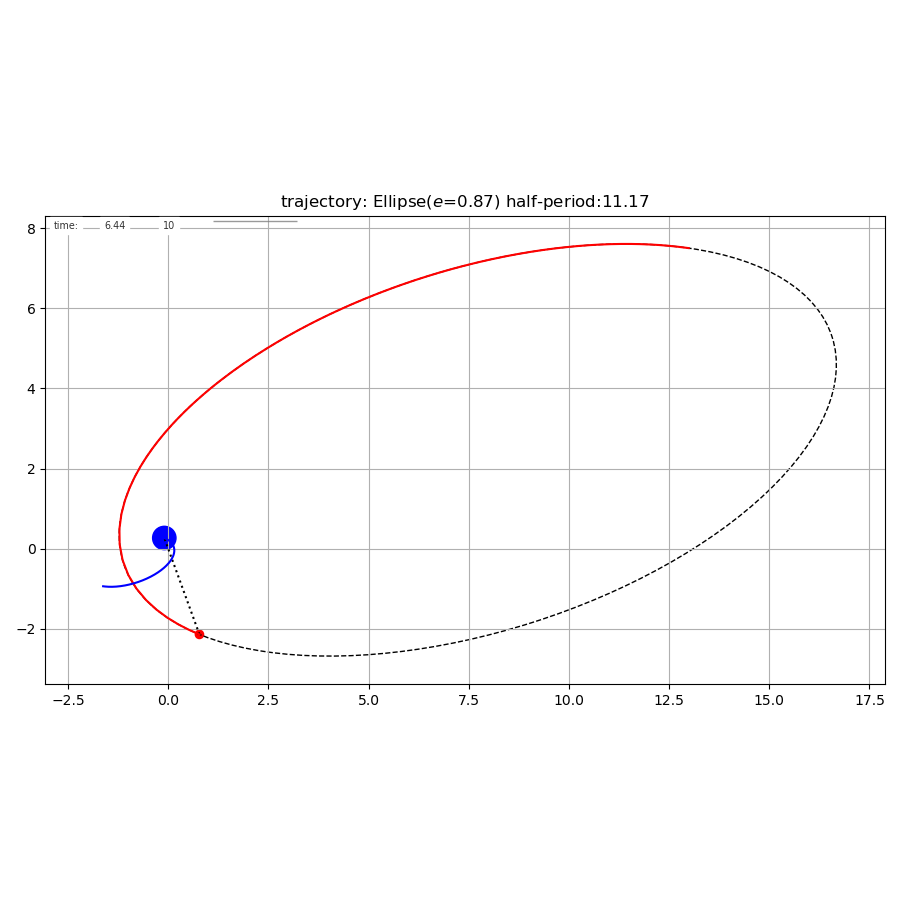

In [4]:
syst = G2body(G=1,M1=10,M2=80)
#syst = G2body(G=.1,M1=10,M2=400)
#syst = G2body(G=1,M1=10,M2=10)
ini = dict(r=15.,rʹ=-1.,θ=30.,θʹ=3.) # elipse
#ini = dict(r=15.,rʹ=-5.,θ=30.,θʹ=3.) # hyperbola
#ini = dict(r=15.,rʹ=-sqrt(2*syst.a/15.-square(15*pi/180*3)),θ=30.,θʹ=3.) # parabola
#ini = dict(r=15.,rʹ=.7,θ=30.,θʹ=0) # straight line
syst.launch(ini=syst.makestate(**ini))

We make use of the following notation. Let $\bar{\mathbf{A}}_1=\arctan$ and $\bar{\mathbf{A}}_{-1}=\textrm{artanh}$. Then for any $c\not=0$,
\begin{equation*}
\mathbf{A}_c(u)\triangleq\int\frac{\mathbf{d}{u}}{c+u^2} = \frac{\textrm{sgn}(c)}{\sqrt{|c|}}\bar{\mathbf{A}}_{\textrm{sgn}(c)}(\frac{u}{\sqrt{|c|}})
\end{equation*}
For generality, we extend the strict definition of $\textrm{artanh}$ beyond the interval $(-1,+1)$ with $\textrm{artanh}(x)=\textrm{artanh}(\frac{1}{x})$.

---
## Trajectory when $\lambda\not=0$

In that case $\theta$ is a monotonous function of time (since  $\dot{\theta}=\frac{\lambda}{r^2}\not=0$) hence $\theta{:}\mathcal{D}^{(t)}\xrightarrow{\sim}\mathcal{D}^{(\theta)}$ and both $r$ and $t$ can be expressed as functions of $\theta$.

### Position as a function of angle

Using $\frac{\mathbf{d}{x}}{\mathbf{d}{\theta}}=\frac{\dot{x}}{\dot{\theta}}$ for any quantity $x$, we get
\begin{equation*}
\frac{\mathbf{d}\frac{1}{r}}{\mathbf{d}\theta} = -\frac{1}{r^2}\frac{\dot{r}}{\dot{\theta}} = -\frac{1}{\lambda}\dot{r}
\hspace{1cm}\textrm{hence}\hspace{1cm}
\frac{\mathbf{d}^2\frac{1}{r}}{\mathbf{d}\theta^2} = -\frac{1}{\lambda}\frac{\ddot{r}}{\dot{\theta}} =
-\frac{1}{\lambda^2}r^2\ddot{r}=
-\frac{1}{\lambda^2}r^2(\frac{\lambda^2}{r^3}-\frac{a}{r^2})=
-(\frac{1}{r}-\frac{a}{\lambda^2})
\end{equation*}
Hence $\frac{1}{r}-\frac{a}{\lambda^2}=\frac{1}{p}\cos(\theta-\phi)$, for some constants $p>0$ and $\phi$ defined modulo $2\pi$, which can be made unique e.g. by setting the constraint $\phi\in[\theta_o-\pi,\theta_o+\pi)$ so that $\theta_o\in(\phi-\pi,\phi+\pi]$. Hence

\begin{equation}
r = \frac{p}{\frac{1}{e}+\cos(\theta-\phi)}
\hspace{2cm}
\dot{r} = \frac{\lambda}{p}\sin(\theta-\phi)
\end{equation}

where $e\triangleq\frac{\lambda^2}{ap}$. The integration constants $\lambda,p,e,\phi$ are determined from the initial conditions. More precisely, $\lambda,E$ (angular momentum and total energy) can be straightforwardly expressed in terms of the initial conditions $r_o,\dot{r}_o,\theta_o,\dot{\theta}_o$ and then the other constants $p,e,\phi$ in terms of $\lambda,E$. We have
\begin{equation*}
E =
\frac{\lambda^2}{2p^2}(\sin^2(\theta-\phi)+(\frac{ap}{\lambda^2}+\cos(\theta-\phi))^2)-\frac{a}{p}(\frac{ap}{\lambda^2}+\cos(\theta-\phi))=
\frac{1}{2}(\frac{\lambda^2}{p^2}-\frac{a^2}{\lambda^2})=
\frac{a^2}{2\lambda^2}(e^2-1)
\end{equation*}
Hence

\begin{equation*}
e = \sqrt{1+2E\frac{\lambda^2}{a^2}}
\hspace{2cm}
p \triangleq \frac{\lambda^2}{ae}
\hspace{2cm}
\left\{
\begin{array}{l}
\cos(\theta_o-\phi) = \frac{p}{r_o}-\frac{1}{e}\\
\sin(\theta_o-\phi) =\frac{p}{\lambda}\dot{r}_o\\
\phi\in[\theta_o-\pi,\theta_o+\pi)
\end{array}
\right.
\end{equation*}

The trajectory is a conic section focussed on the origin. It is an hyperbola if $e>1$ (i.e. $E>0$), or a parabola if $e=1$ (i.e. $E=0$), or an ellipse if $e<1$ (i.e. $E<0$). The limit case $e=0$ with $p=\infty$ while keeping $pe=\frac{\lambda^2}{a}$ (i.e. $E=-\frac{a^2}{2\lambda^2}$) corresponds to the circle $r=\frac{\lambda^2}{a}$. In that case, $\phi$ is undefined.

### Time as a function of angle

Observe that $r\geq\frac{p}{e^{-1}+1}>0$ hence we cannot have $\lim_{t\rightarrow\tau}r(t)=0$ at any bound $\tau$ of $\mathcal{D}^{(t)}$. Hence $\mathcal{D}^{(t)}$ has no finite bound, hence $\mathcal{D}^{(t)}=\mathbb{R}$.

The angular speed is given by $\dot{\theta}=\frac{\lambda}{r^2}$. If $e=0$, then $r=\frac{\lambda^2}{a}$ hence $\dot{\theta}=\frac{a^2}{\lambda^3}$, and $\theta=\theta_o+\frac{a^2}{\lambda^3}t$. If $e>0$, then

\begin{equation}
\dot{\theta}=\frac{\lambda}{p^2}(\frac{1}{e}+\cos(\theta-\phi))^2
\end{equation}

Consider a time interval $\mathcal{T}$ and instant $t^*$ such that

* $\mathcal{T}$ contains both the initial time $0$ as well as time $t^*$, and $\theta(t^*)=\phi$

* $1+\cos(\theta(t)-\phi)\not=0$ over the interior of $\mathcal{T}$, hence $\cos\frac{\theta(t)-\phi}{2}\not=0$.

Let $\Theta\subset\mathcal{D}^{(\theta)}$ be the image of $\mathcal{T}$ by $\theta$. Hence $\cos\frac{\theta-\phi}{2}\not=0$ on $\Theta$. Let $u\triangleq\tan\frac{\theta-\phi}{2}$. Clearly, $u{:}\Theta{\xrightarrow{\sim}}\mathcal{U}$ for some interval $\mathcal{U}$ and $t$ over $\mathcal{T}$ can now be expressed as a function of $u$. Note that $\frac{\mathbf{d}{u}}{\mathbf{d}{\theta}}=\frac{1}{2}(1+u^2)$. Using $\cos(\theta-\phi)=\frac{1-u^2}{1+u^2}$, we can write
\begin{equation*}
\frac{\mathbf{d}{t}}{\mathbf{d}{u}} = \frac{1}{\dot{\theta}}\frac{\mathbf{d}{\theta}}{\mathbf{d}{u}} =
\frac{2p^2e^2}{\lambda(1+u^2)(1+e\frac{1-u^2}{1+u^2})^2} =
\frac{2p^2e^2}{\lambda}\frac{1+u^2}{(1+e+u^2(1-e))^2}
\end{equation*}
This equation, after integration of the right-hand side, can be used to determine the visit time of any position $\theta$ in $\Theta$, relative to $t^*$ where $\theta^*=\phi$ hence $u^*=0$. Since $\theta_o\in\Theta$ is visited exactly at time $t=0\in\mathcal{T}$, it can also be used to compute $t^*$.

* When $E=0$, i.e. $e=1$, we have $\frac{\mathbf{d}{t}}{\mathbf{d}{u}} = \frac{p^2}{\lambda}(1+u^2) = \frac{p^2}{\lambda}\frac{\mathbf{d}}{\mathbf{d}{u}}\left(u+\frac{u^3}{3}\right)$, hence
\begin{equation*}
t-t^* = \frac{\lambda^3}{a^2}(u+\frac{u^3}{3})
\hspace{.5cm}\textrm{where}\hspace{.5cm}
u\triangleq\tan\frac{\theta-\phi}{2}
\end{equation*}

* When $E\not=0$, i.e. $e\not=1$, let $c\triangleq\frac{1+e}{1-e}$ and we have
\begin{align*}
\frac{\mathbf{d}{t}}{\mathbf{d}{u}} & =
\frac{2p^2e^2}{\lambda(1-e)^2} \frac{1+u^2}{(c+u^2)^2} =
\frac{2p^2e^2}{\lambda(1-e)^2}\left(\frac{1-c}{2c}\frac{c-u^2}{(c+u^2)^2}+\frac{1+c}{2c}\frac{1}{c+u^2}\right) \\
& =
\frac{2p^2e^2}{\lambda(1-e)^2(1+e)}\left(-e\frac{c-u^2}{(c+u^2)^2}+\frac{1}{c+u^2}\right) =
\frac{2p^2e^2}{\lambda(1-e)^2(1+e)}\frac{\mathbf{d}}{\mathbf{d}{u}}\left(-\frac{eu}{c+u^2}+\mathbf{A}_c(u)\right)
\end{align*}
After simplifications,

\begin{equation}
\label{eqn:time-at-pos}
t-t^* = 2a|2E|^{-\frac{3}{2}}\sigma\textrm{sgn}(\lambda)\left(\bar{\mathbf{A}}_{\sigma}(\bar{u})-\frac{e\bar{u}}{1+\sigma \bar{u}^2}\right)
\hspace{.5cm}\textrm{where}\hspace{.5cm}
\bar{u}\triangleq\frac{\tan\frac{\theta-\phi}{2}}{\sqrt{|\frac{1+e}{1-e}|}}
\hspace{.3cm}\textrm{and}\hspace{.3cm}
\sigma=-\textrm{sgn}(E)
\end{equation}

### Admissible solution set

Therefore, the problem reduces to computing an admissible pair $\langle\mathcal{T},t^*\rangle$ satisfying the constraints above.

* If $E<0$ hence $\sigma=1$ and $e<1$, the trajectory is an ellipse. We can build $\mathcal{T}$ of the form $[t^*-T,t^*+T]$, s.t. $\theta(t^*)=\phi$ and $\theta(t^*+T)=\phi+\pi$. Then $\theta$ is incrementally periodic: $\theta(t+2kT)=\theta(t)+2k\pi$ for any $k\in\mathbb{Z}$. The half-period $T$ (duration of a half revolution on the ellipse) is given by
\begin{equation*}
|T| = \pi a|2E|^{-\frac{3}{2}}
\hspace{2cm}
\textrm{sgn}(T)=\textrm{sgn}(\lambda)
\end{equation*}
The visit time of any $\theta\in\mathbb{R}$ can be computed by writing $\theta=\bar{\theta}+2k\pi$ where $\bar{\theta}\in\Theta$ and $k\in\mathbb{Z}$, then using the equation above to compute the visit time $\bar{t}\in\mathcal{T}$ of $\bar{\theta}$, and finally writing $t=\bar{t}+2kT$.

* If $E\geq0$ hence $\sigma=-1$ and $e\geq1$, the trajectory is a parabola or hyperbola. We can take $\mathcal{T}=\mathbb{R}$, the equation above can be used directly to compute the visit time of any feasible $\theta$, i.e. such that $\theta\in(\phi-\psi_e,\phi+\psi_e)$ where $\psi_e\triangleq\arccos-\frac{1}{e}$.

---
## Trajectory when $\lambda=0$

In that case $\dot{\theta}=0$ hence the trajectory is included in the straight half-line $\theta=\theta_o$. The equation of the total energy becomes $\dot{r}^2 = 2a(\frac{1}{r}-c)$ where $c\triangleq-\frac{E}{a}$.

### Time as a function of position

Consider a time interval $\mathcal{T}$, instant $t^*$ and $\epsilon\in\{-1,+1\}$ such that

* $r$ is increasing (if $\epsilon=1$) or decreasing (if $\epsilon=-1$) on $\mathcal{T}$.

* $t^*$ is a boundary of $\mathcal{T}$ and $\dot{r}^*\triangleq\lim_{t\rightarrow t^*}\dot{r}(t)=0$ if $c>0$ and $r^*\triangleq\lim_{t\rightarrow t^*}r(t)=0$ if $c\leq0$.

The main equation on $\mathcal{T}$ becomes
\begin{equation*}
\dot{r} = \epsilon\sqrt{2a}\sqrt{\frac{1}{r}-c}
\end{equation*}
Clearly, $r{:}\mathcal{T}{\xrightarrow{\sim}}\mathcal{R}$ for some interval $\mathcal{R}$ and $t$ can be expressed as a function of $r$.

When $E=0$, i.e. $c=0$, we have $\frac{\mathbf{d}{t}}{\mathbf{d}{r}} = \frac{1}{\dot{r}} = \frac{\epsilon}{\sqrt{2a}}r^{\frac{1}{2}} = \frac{\epsilon}{\sqrt{2a}}\frac{\mathbf{d}}{\mathbf{d}{r}}\left(\frac{2}{3}r^{\frac{3}{2}}\right)$, hence

\begin{equation*}
t-t^*=\frac{\epsilon}{3}\sqrt{\frac{2}{a}}r^{\frac{3}{2}}
\end{equation*}

When $E\not=0$, i.e. $c\not=0$, let $u\triangleq\sqrt{\frac{1}{r}-c}$. Clearly, $u{:}\mathcal{R}{\xrightarrow{\sim}}\mathcal{U}$ for some interval $\mathcal{U}$ and $t$ can now be expressed as a function of $u$. Note that $r=\frac{1}{c+u^2}$ and $\frac{\mathbf{d} r}{\mathbf{d} u}=\frac{-2u}{(c+u^2)^2}$. Hence
\begin{align*}
\frac{\mathbf{d} t}{\mathbf{d} u} = \frac{1}{\dot{r}}\frac{\mathbf{d} r}{\mathbf{d} u} & =
\frac{-2u}{\epsilon\sqrt{2a}u(c+u^2)^2} =
-\epsilon\sqrt{\frac{2}{a}}\frac{1}{(c+u^2)^2} =
-\epsilon\sqrt{\frac{2}{a}}\frac{1}{2c}\left(\frac{c-u^2}{(c+u^2)^2}+\frac{1}{c+u^2}\right)\\
& =
\frac{-\epsilon}{c\sqrt{2a}}\frac{\mathbf{d}}{\mathbf{d} u}\left(\frac{u}{c+u^2}+\mathbf{A}_c(u)\right)
\end{align*}
This can now be integrated from $t^*$ where $r^*$ is either $0$ (if $c<0$) or $\frac{1}{c}$ (if $c>0$) hence $u^*$ is either $\infty$ (if $c<0$) or $0$ (if $c>0$). In both cases, $\mathbf{A}_c(u^*)=0$ (recall that when $c<0$ and $u^*=\infty$, it is first inverted in the computation of $\textrm{artanh}$). After simplifications,

\begin{equation}
\label{eqn:time-at-pos-degenerate}
t-t^* = -2a|2E|^{-\frac{3}{2}}\epsilon \left(\bar{\mathbf{A}}_\sigma(\bar{u})+\frac{\bar{u}}{1+\sigma\bar{u}^2}\right)
\hspace{.5cm}\textrm{where}\hspace{.5cm}
\bar{u}\triangleq\sqrt{\frac{a}{r|E|}-\sigma}
\hspace{.3cm}\textrm{and}\hspace{.3cm}
\sigma=-\textrm{sgn}(E)
\end{equation}

### Admissible solution set

Therefore, the problem reduces to computing an admissible triple $\langle\mathcal{T},t^*\epsilon\rangle,$ satisfying the constraints above.

* If $E<0$ hence $\sigma=1$ the time domain $\mathcal{D}^{(t)}$ is of the form $(t^*-T,t^*+T)$ where $\dot{r}(t^*)=0$, i.e. $r(t^*)=\frac{1}{c}$. The trajectory is the segment $(0,\frac{1}{c}]$ on the straight half-line $\theta=\theta_o$. We can compute the half-duration $T$ of the trajectory by applying the equation above at $r=\frac{1}{c}$ on $[t^*,t^*+T)$ where $\bar{u}=\infty$ hence $\bar{\mathbf{A}}_1(\bar{u})=\frac{\pi}{2}$.
\begin{equation*}
T = \pi a|2E|^{-\frac{3}{2}}
\end{equation*}
There is no periodicity though, because the trajectory cannot cross the origin. The visit times of any feasible $r$, i.e. such that $r\leq\frac{1}{c}$, can be computed by selecting $\epsilon=+1$ for the interval $(t^*-T,t^*]$ or $\epsilon=-1$ for the interval $[t^*,t^*+T)$ then using the equation above.

* If $E\geq0$ hence $\sigma=-1$ the time domain $\mathcal{D}^{(t)}$ is of the form either $(-\infty,t^*)$ with $\epsilon=-1$ or $(t^*,+\infty)$ with $\epsilon=+1$ where $\lim_{t\rightarrow t^*}\theta(t)=0$ and $\lim_{t\rightarrow\epsilon\infty}\theta(t)=\infty$. The trajectory is the whole straight half-line $\theta=\theta_o$. We can take $\mathcal{T}=\mathcal{D}^{(t)}$ and the equation above can be used directly to compute the visit time of any $r>0$.
